# ライブラリ読み込み

In [1]:
import numpy as np
import pandas as pd; pd.set_option('display.max_columns', None)
import matplotlib.pyplot as plt

# utility
import time
import copy as cp
from tqdm import tqdm
from collections import defaultdict
import glob
import os
import sys
from sys import stderr

# 乱数
rng = np.random.RandomState(1234)
random_state = 42

# pytorch
# conda install pytorch torchvision -c pytorch
import torch
import torch.nn as nn
import torch.optim as optim
import torch.autograd as autograd
import torch.nn.functional as F
from torchvision import datasets, transforms, models

# 囲碁ライブラリ
from sgfmill import sgf
from sgfmill import boards

# ルートに移動
%cd /Users/keimy/git/humanized-models-for-board-games/igo
%pwd


/Users/keimy/git/humanized-models-for-board-games/igo


'/Users/keimy/git/humanized-models-for-board-games/igo'

# Visualize Data

In [2]:
# .npy ファイルからデータをロード
move_tensors = np.load('./preprocess/tensors_at_move.npy')

move_tensors.shape

(55191, 2, 19, 19)

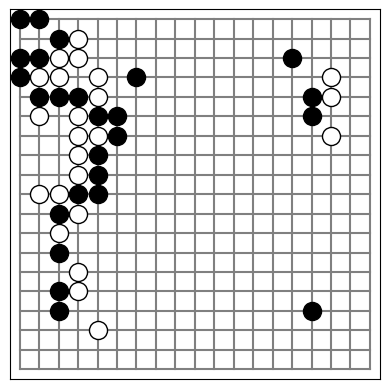

0

In [5]:
from src.board import visualize_matrix

black_matrix, white_matrix = move_tensors[200]
visualize_matrix(black_matrix, white_matrix)


# Make Dataloaders

In [3]:
import torch
from torch.utils.data import Dataset, DataLoader

# トレーニングセットと検証セットに分割
train_size = int(0.8 * len(move_tensors))
valid_size = len(move_tensors) - train_size
train_dataset, valid_dataset = torch.utils.data.random_split(move_tensors, [train_size, valid_size])

# データローダーの設定
batch_size = 128
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)


# VAE-linear

In [4]:
from src.model.VAE_linear import VAE_linear
z_dim = 10
assert z_dim >= 2
input_dim =  2 * 19 * 19
n_epochs = 10

device = "mps" if torch.backends.mps.is_available() else "cpu"
model = VAE_linear(z_dim = z_dim, input_dim = input_dim).to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)


for epoch in range(n_epochs):
    losses = []
    KL_losses = []
    reconstruction_losses = []

    model.train()
    for x in train_loader:
        x = x.float().to(device)  # データ型をfloatに変換してからデバイスに送る

        model.zero_grad()

        # KL_loss, reconstruction_lossの各項の計算
        KL_loss, reconstruction_loss = model.loss(x)

        # エビデンス下界の最大化のためマイナス付きの各項の値を最小化するようにパラメータを更新
        loss = KL_loss + reconstruction_loss

        loss.backward()
        optimizer.step()

        losses.append(loss.cpu().detach().numpy())
        KL_losses.append(KL_loss.cpu().detach().numpy())
        reconstruction_losses.append(reconstruction_loss.cpu().detach().numpy())

    losses_val = []
    model.eval()
    for x in valid_loader:
        x = x.float().to(device)  # ここでも同様にデータ型をfloatに変換

        KL_loss, reconstruction_loss = model.loss(x)

        loss = KL_loss + reconstruction_loss

        losses_val.append(loss.cpu().detach().numpy())

    print('EPOCH: %d    Train Lower Bound: %lf (KL_loss: %lf. reconstruction_loss: %lf)    Valid Lower Bound: %lf' %
          (epoch+1, np.average(losses), np.average(KL_losses), np.average(reconstruction_losses), np.average(losses_val)))


EPOCH: 1    Train Lower Bound: 0.657075 (KL_loss: 0.026440. reconstruction_loss: 0.630635)    Valid Lower Bound: 0.600519
EPOCH: 2    Train Lower Bound: 0.600452 (KL_loss: 0.000884. reconstruction_loss: 0.599568)    Valid Lower Bound: 0.599975


KeyboardInterrupt: 

# Visualize Reconstruction

任意のxをもとに可視化

In [ ]:
model.eval()

i = 50
x = valid_dataset[i]
x = torch.from_numpy(x).float()
x = x.to(device)

y, z = model(x)

print(z)
black_matrix, white_matrix = y.squeeze()
visualize_matrix(black_matrix, white_matrix)

Zのランダムサンプリング

In [ ]:
z = torch.randn([1, z_dim]).to(device)

model.eval()
y = model._decoder(z)

print(z)
black_matrix, white_matrix = y.squeeze()
visualize_matrix(black_matrix, white_matrix)